In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

cell_data = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/cell_phones_total.csv")
pop_data = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/pop_data.csv")
country_data = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/country_data.csv")


In [3]:
# CLEANED DATA FROM THE PREVIOUS HOMEWORK 

# Function to convert string values to numeric
def convert_to_numeric(value):
    if isinstance(value, str):
        multipliers = {'k': 1e3, 'M': 1e6, 'B': 1e9}
        try:
            return float(value[:-1]) * multipliers.get(value[-1], 1)
        except ValueError:
            return np.nan  # Handle invalid entries
    return value  # If not a string, return as-is

# Apply conversion function to all columns except 'iso-3'
for col in cell_data.columns[1:]:
    cell_data[col] = cell_data[col].apply(convert_to_numeric)

# Convert remaining non-numeric columns to numeric and handle missing values
cell_data.update(cell_data[cell_data.columns[1:]].apply(pd.to_numeric, errors='coerce'))  # Coerce non-numeric entries to NaN
cell_data[cell_data.columns[1:]] = cell_data[cell_data.columns[1:]].ffill(axis=1)  # Use ffill() to forward-fill missing values across years

# Filter columns and sort by 2015
sorted_df = cell_data[['iso-3', '2015', '2016', '2017', '2018', '2019']].sort_values(by='2015', ascending=False)

sorted_df.head()

,iso-3,2015,2016,2017,2018,2019
35,CHN,1.290000e+09,1.360000e+09,1.470000e+09,1.650000e+09,1.730000e+09
87,IND,1.000000e+09,1.130000e+09,1.170000e+09,1.180000e+09,1.150000e+09
200,USA,3.820000e+08,3.960000e+08,4.000000e+08,4.220000e+08,4.220000e+08
86,IDN,3.390000e+08,3.860000e+08,4.350000e+08,3.190000e+08,3.450000e+08
26,BRA,2.580000e+08,2.440000e+08,2.180000e+08,2.070000e+08,2.070000e+08


In [5]:
# Reshape cell phone data to long format
cell_data_melted = cell_data.melt(id_vars='iso-3', var_name='year', value_name='n_cellphones')
cell_data_melted['year'] = pd.to_numeric(cell_data_melted['year'])

# Drop unnecessary index column in pop_data if it exists
if 'Unnamed: 0' in pop_data.columns:
    pop_data = pop_data.drop(columns=['Unnamed: 0'])

# Forward-fill missing values in the population data
pop_data = pop_data.ffill(axis=1)

# Reshape population data to long format
pop_data_melted = pop_data.melt(id_vars='iso-3', var_name='year', value_name='population')
pop_data_melted['year'] = pd.to_numeric(pop_data_melted['year'], errors='coerce')
pop_data_melted.dropna(subset=['year'], inplace=True)  # Remove rows with invalid year values

# Merge cell phone and population data
merged_data = pd.merge(cell_data_melted, pop_data_melted, on=['iso-3', 'year'], how='inner')

# Add country names from country_data
merged_data = pd.merge(merged_data, country_data[['alpha-3', 'name']], left_on='iso-3', right_on='alpha-3', how='left')
merged_data = merged_data.rename(columns={'name': 'country'})
merged_data = merged_data.drop(columns=['alpha-3'])  # Drop redundant column

# Calculate cell phones per capita
merged_data['phones_per_capita'] = merged_data['n_cellphones'] / merged_data['population']

# Filter data for the years 2015-2019
filtered_data = merged_data[(merged_data['year'] >= 2015) & (merged_data['year'] <= 2019)]

# Find top 5 countries in 2019 based on phones per capita
top_countries_2019 = (
    filtered_data[filtered_data['year'] == 2019]
    .sort_values(by='phones_per_capita', ascending=False)
    .head(5)['country']
    .tolist()
)

In [6]:
# Display the final merged table (with only the specified columns)
merged_data[['iso-3', 'year', 'n_cellphones', 'population']].head()

,iso-3,year,n_cellphones,population
0,ABW,1960,0.0,54608.0
1,AFG,1960,0.0,8622466.0
2,AGO,1960,0.0,5357195.0
3,ALB,1960,0.0,1608800.0
4,AND,1960,0.0,9443.0


In [5]:
# Create a pivot table for top 5 countries
table = merged_data[merged_data['country'].isin(top_countries_2019)].pivot(
    index='year', columns='country', values='phones_per_capita'
)

# Limit the data to the years 2010–2019
table = table.loc[2010:2019]

table

country,Antigua and Barbuda,Hong Kong,Macao,Seychelles,United Arab Emirates
year,,,,,
2010,1.960441,1.964637,2.0097,1.31447,1.285109
2011,2.02931,2.163584,2.364261,1.452408,1.364399
2012,1.448548,2.293674,2.762687,1.540152,1.59262
2013,1.288179,2.368051,2.898678,1.523085,1.839612
2014,1.344749,2.351477,3.078619,1.65282,1.901323
2015,1.956838,2.290401,3.088231,1.58426,2.007424
2016,1.987545,2.398931,3.14351,1.605459,2.212521
2017,2.019337,2.488773,3.210102,1.742433,2.183431
2018,2.008164,2.670209,3.348741,1.8499,2.199084


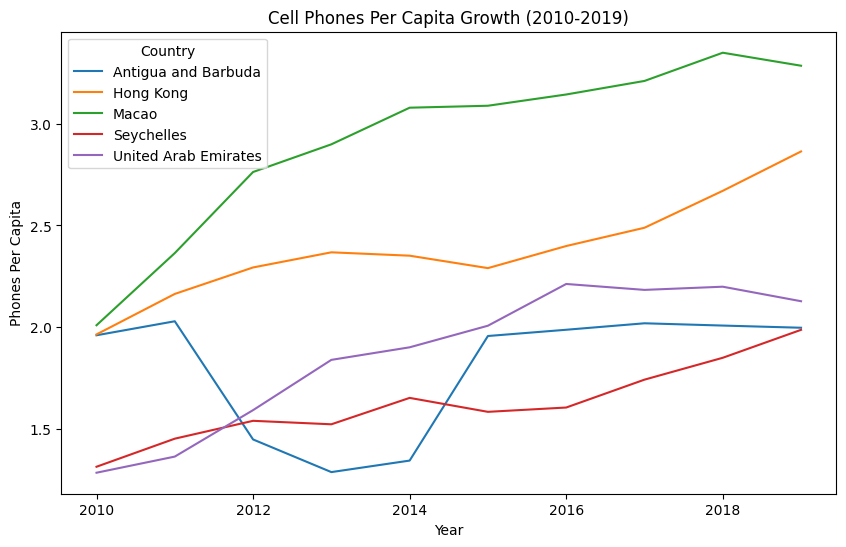

In [30]:
# Plot growth rate for the top countries
table.plot(title="Cell phones per capita growth 2010-2019", figsize=(10, 6))
plt.ylabel("Phones per capita")
plt.xlabel("Year")
plt.legend(title="Country")
plt.show()

# SQL

Retrieve the usernames of all users who have performed the "signup" action.

In [12]:
import sqlite3

# Connect to the SQLite database
connection = sqlite3.connect("user_actions.db")
cursor = connection.cursor()

query = "SELECT username FROM user_actions WHERE action = 'signup';"
pd.read_sql_query(query, connection)

,username
0,user34
1,user28
2,user1
3,user24
4,user15
5,user20
6,user18
7,user25
8,user3
9,user9


Find the total number of log entries for each user. Display the user_id, username, and the count of log entries.

In [6]:
query = """
SELECT 
    user_id, 
    username, 
    COUNT(*) AS log_entry_count
FROM 
    user_actions
GROUP BY 
    user_id, username
ORDER BY 
    log_entry_count DESC;
"""
pd.read_sql_query(query, connection)


,user_id,username,log_entry_count
0,13,user13,470
1,6,user6,457
2,4,user4,436
3,35,user35,394
4,31,user31,389
5,16,user16,379
6,17,user17,367
7,7,user7,362
8,20,user20,362
9,8,user8,329


Identify users who have both logged in (action = 'login') and signed up (action = 'signup') on the same day. Display the user_id and username.

In [11]:
query = """
SELECT DISTINCT 
    u1.user_id, 
    u1.username
FROM 
    user_actions u1
JOIN 
    user_actions u2
ON 
    u1.user_id = u2.user_id 
    AND DATE(u1.timestamp) = DATE(u2.timestamp)
WHERE 
    u1.action = 'login' 
    AND u2.action = 'signup';
"""
pd.read_sql_query(query, connection)

,user_id,username
0,8,user8
1,12,user12
2,30,user30
3,7,user7
4,22,user22
5,5,user5
6,2,user2
7,32,user32


# Regex

Write a regular expression to extract all hashtags from a given comment. For example, applying the regex to comment 1 should return ["#programming", "#tips"].

In [14]:
import re

data = pd.read_csv("https://raw.githubusercontent.com/su-mt4007/data/refs/heads/main/comments.txt")

# Extract comments from the appropriate column (adjusted for column name)
comments = data.iloc[:, 0].tolist()

# Add column name to the beginning of the list of comments
comments = [data.columns[0]] + comments

# Regular expression pattern to match hashtags
hashtag_pattern = r"#\w+"

# Function to extract hashtags from a specific comment (based on its index in the list)
def extract_hashtags(index):
    return re.findall(hashtag_pattern, comments[index])

# Example: Extract hashtags from the first comment (index 0)
hashtags_in_first_comment = extract_hashtags(0)
print(hashtags_in_first_comment)

['#programming', '#tips']


Create a regular expression to find comments that mention both "#programming" and "#python". Apply the regex to comment 2 and check if it matches.

In [15]:
# Regular expression pattern to check for both #programming and #python in a comment
hashtag_check_pattern = r"(?=.*#programming)(?=.*#python)"

# Choose the second comment (index 1)
comment_to_check = comments[1]

# Check if both hashtags are mentioned in the second comment
if re.search(hashtag_check_pattern, comment_to_check):
    print(comment_to_check)  # Print the comment if both hashtags are found
else:
    print("No match")

No match
